In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import statsmodels.api as sm

C:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#read in members and train datafiles
members = pd.read_csv(r'C:\Users\liconver\Downloads\members_v3.csv')
train = pd.read_csv(r'C:\Users\liconver\Downloads\train.csv')
#create dataframe df
df = pd.merge(members,train,how='inner',on=['msno'])

In [3]:
#read in first 50 million rows of user logs file
user_logs= pd.read_csv(r'C:\Users\liconver\Downloads\user_logs.csv')
user_logs['date'] = pd.to_datetime(user_logs['date'],format='%Y%m%d')
#select only logs for users that are in df
msnos = df['msno']
relevant_user_logs = user_logs.loc[user_logs['msno'].isin(msnos)]
user_logs = []

In [4]:
#select only logs for the last two months before the churn window, which for the train set is February 2017
LastTwoMonthslogs = relevant_user_logs.loc[(relevant_user_logs['date']<'2017-02-01') & (relevant_user_logs['date']>'2016-11-30')]
del relevant_user_logs

In [5]:
#aggregate the logs by mean so you can have one row of log info per user
mean_user_logs = pd.DataFrame(index=[],columns=[])
mean_user_logs['num_25'] = LastTwoMonthslogs.groupby('msno')['num_25'].mean()
mean_user_logs['num_50'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_75'] = LastTwoMonthslogs.groupby('msno')['num_75'].mean()
mean_user_logs['num_985'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_100'] = LastTwoMonthslogs.groupby('msno')['num_100'].mean()
mean_user_logs['num_unq'] = LastTwoMonthslogs.groupby('msno')['num_unq'].mean()
mean_user_logs['total_secs'] = LastTwoMonthslogs.groupby('msno')['total_secs'].mean()
mean_user_logs['days_logged'] = LastTwoMonthslogs.groupby('msno')['date'].count()

In [6]:
#merge the mean log data into the dataframe
mean_user_logs = mean_user_logs.reset_index()
df = pd.merge(df,mean_user_logs,how='inner',on='msno')

In [7]:
#replace date of initial registration with a numeric feature for how many days users has been registered
df['registration_init_time'] = pd.to_datetime(df['registration_init_time'],format='%Y%m%d')
end_day = datetime.date(2017,3,1)
df['days_since_registered'] = end_day - df['registration_init_time']
df['days_since_registered'] = df['days_since_registered'].dt.days
df = df.drop(['registration_init_time'],axis=1)

In [8]:
#replace columns that have categorical data with dummy variables
df = pd.get_dummies(df,columns=['city','registered_via','gender'])

In [9]:
#check how many churners are in the dataframe relative to the size of the dataframe
print(df.is_churn.sum())
print(df.shape)

51248
(798141, 40)


In [10]:
#subset the dataframe into churners and nonchurners and reconstruct with a higher ratio of churners
churners= df.loc[df['is_churn']==1]
nonchurners= df.loc[df['is_churn']==0]
nonchurners= nonchurners.sample(n=107000)
df = pd.concat([churners,nonchurners])

In [11]:
#identify features and target variable for calculating VIF
y = df['is_churn']
X = df.drop(['is_churn','msno'],axis=1)

In [11]:
#display vif of all features
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

C:\Users\liamc\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,1.934917,bd
1,1.868850,num_25
2,inf,num_50
3,2.323106,num_75
4,inf,num_985
5,32.715950,num_100
6,4.139891,num_unq
7,36.472611,total_secs
8,1.046762,days_logged
9,1.682419,days_since_registered


In [12]:
#select features and target variable for model.  Can change to eliminate high VIF features
y = df['is_churn']
X = df.drop(['is_churn','msno'],axis=1)

In [13]:
#split into train and test sets and initialize classifier
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=21)
logreg = LogisticRegression()

In [14]:
#train
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
#make predictions on test set
y_pred = logreg.predict(X_test)

In [16]:
#check confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[28142  3895]
 [ 9127  6311]]
             precision    recall  f1-score   support

          0       0.76      0.88      0.81     32037
          1       0.62      0.41      0.49     15438

avg / total       0.71      0.73      0.71     47475



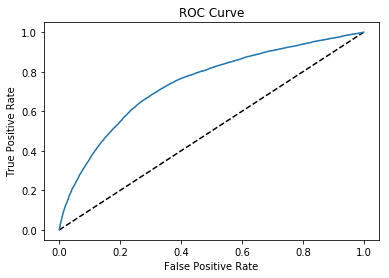

AUC: 0.7413272412873535
AUC scores computed using 5-fold cross-validation: [0.71848695 0.73876395 0.75123381 0.76437934 0.73612926]


In [17]:
#Check ROC curve, AUC score, and 5 fold cv AUC
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(logreg,X,y,cv=5,scoring='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

In [18]:
#check log loss
log_loss(y_test,y_pred_prob)

0.5490062477265323

In [19]:
#model coefficients
logreg.coef_

array([[-8.99947652e-03,  1.84103775e-03,  2.32805244e-03,
         1.87106308e-03,  2.32805244e-03,  4.49160780e-04,
        -9.01216760e-04, -7.67110940e-06, -1.46812551e-01,
        -3.73385307e-04, -5.42924759e-01, -4.11212625e-03,
         1.84767379e-03, -1.59909631e-03, -1.61660787e-02,
        -4.31933247e-03,  4.70523316e-03, -8.44091138e-03,
         4.90314419e-03, -1.30978247e-02,  1.89582933e-02,
        -6.80546874e-02, -1.26298217e-02, -3.06300620e-02,
        -7.98428291e-04, -9.52326292e-03, -6.81295009e-03,
         9.46910250e-05,  1.51493793e-03,  5.22189170e-03,
        -3.48725330e-02,  1.65067124e-01,  1.93517957e-01,
        -1.22943798e+00,  1.75145614e-01, -2.10287266e-02,
         5.26606001e-02,  6.42125977e-02]])